In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import pymysql
pymysql.install_as_MySQLdb()

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
hawaii_data = pd.read_sql('SELECT * FROM station', conn)

In [6]:
hawaii_data.head()

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [7]:
# Inspect database
inspector = inspect(engine)
inspector.get_table_names()

# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [8]:
# Check the dates
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
earliest_date

('2010-01-01')

In [9]:
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date

('2017-08-23')

In [10]:
# Calculate the date 1 year ago from the last data point in the database
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
one_year_ago

datetime.date(2016, 8, 23)

In [11]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precipitation)
precip_df.set_index('date')
precip_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


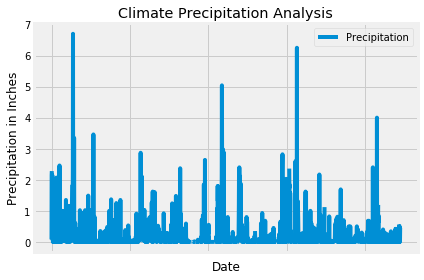

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot('date', 'prcp')
plt.title("Climate Precipitation Analysis")
plt.xlabel("Date")
plt.ylabel("Precipitation in Inches")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement).group_by(Measurement.station).count()

9

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()

active_stations_df = pd.DataFrame(data=active_stations, columns=['Station', 'Count'])
active_stations_df .head()

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, highest temperature recorded, and average temperature most active station?
most_active_station = active_stations[0][0]
session.query(func.min(Measurement.tobs),
              func.max(Measurement.tobs), 
              func.avg(Measurement.tobs)).\
                filter(Measurement.station == most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active_station).\
                filter(Measurement.date >= one_year_ago).all()
tobs_df = pd.DataFrame(temp_data)
tobs_df.head()

,station,tobs
0,USC00519281,77.0
1,USC00519281,77.0
2,USC00519281,80.0
3,USC00519281,80.0
4,USC00519281,75.0


<function matplotlib.pyplot.show(*args, **kw)>

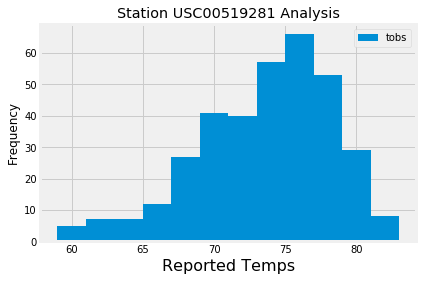

In [19]:
# Plot the results as a histogram with bins=12.
tobs_df.plot.hist(by='station', bins=12)
plt.title("Station USC00519281 Analysis")
plt.xlabel("Reported Temps", fontsize=16)
plt.ylabel("Frequency")
plt.show